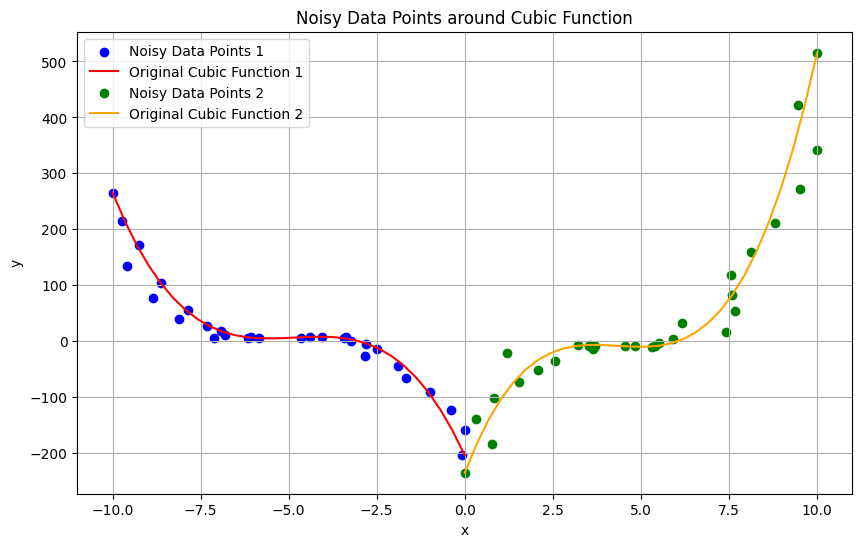

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


def poly1(x):
    return -2*x**3 + x**2 + 3*x + 6

def poly2(x):
    return 3*x**3 + 6*x**2 - 10


def data_generator(data_size=30, noise_std=0.5):
    x1 = torch.linspace(-10, 0, steps=data_size) 
    x2 = torch.linspace(0, 10, steps=data_size)
    y1 = poly1(x1+5)
    y2 = poly2(x2-5)

    noisy_x1 = x1 + torch.randn_like(x1) * noise_std
    noisy_x1 = torch.clamp(noisy_x1, min=-10, max=0)
    noisy_x2 = x2 + torch.randn_like(x2) * noise_std
    noisy_x2 = torch.clamp(noisy_x2, min=0, max=10)
    noisy_y1 = y1 + torch.randn_like(y1) * noise_std
    noisy_y2 = y2 + torch.randn_like(y2) * noise_std


    return noisy_x1, noisy_y1, noisy_x2, noisy_y2, x1, y1, x2, y2

noisy_x1, noisy_y1, noisy_x2, noisy_y2, x1_normal, y1_normal, x2_normal, y2_normal = data_generator()

plt.figure(figsize=(10, 6))

plt.scatter(noisy_x1.numpy(), noisy_y1.numpy(), label='Noisy Data Points 1', color='blue')
plt.plot(x1_normal.numpy(), y1_normal.numpy(), label='Original Cubic Function 1', color='red')
plt.scatter(noisy_x2.numpy(), noisy_y2.numpy(), label='Noisy Data Points 2', color='green')
plt.plot(x2_normal.numpy(), y2_normal.numpy(), label='Original Cubic Function 2', color='orange')

plt.title('Noisy Data Points around Cubic Function')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

In [3]:
class DynamicLinearRegression(nn.Module):
    def __init__(self, num_layers, layer_nodes):
        super().__init__()
        self.num_layers = num_layers
        self.input = nn.Linear(1, layer_nodes[0]) 
        self.hidden_layers = nn.ModuleList([nn.Linear(layer_nodes[i], layer_nodes[i+1]) for i in range(num_layers - 1)])
        self.output = nn.Linear(layer_nodes[-1], 1)

    def forward(self, x):
        x = torch.relu(self.input(x))
        for layer in self.hidden_layers:
            x = torch.relu(layer(x))
        x = self.output(x)
        return x

In [37]:
from torchviz import make_dot
import torch.utils.tensorboard as tb

writer = tb.SummaryWriter()



class LinearRegression3Layer(nn.Module):
    def __init__(self):
        super(LinearRegression3Layer, self).__init__()
        self.hidden1 = nn.Linear(1, 5)
        self.hidden2 = nn.Linear(5, 5)
        self.output = nn.Linear(5, 1)

    def forward(self, x):
        x = torch.relu(self.hidden1(x))
        x = torch.relu(self.hidden2(x))
        x = self.output(x)
        return x

class DynamicLinearRegression(nn.Module):
    def __init__(self, num_layers, layer_nodes):
        super().__init__()
        self.num_layers = num_layers
        self.hidden1 = nn.Linear(1, layer_nodes[0])
        # Slice layer_nodes to get the appropriate range for hidden layers
        self.hidden = nn.ModuleList([nn.Linear(layer_nodes[i-1], layer_nodes[i]) for i in range(1, num_layers - 1)])
        self.output = nn.Linear(layer_nodes[-2], 1)  # Adjusted output layer input size

    def forward(self, x):
        x = torch.relu(self.hidden1(x))
        for layer in self.hidden:
            x = torch.relu(layer(x))
        x = self.output(x)
        return x

model1 = LinearRegression3Layer()
model2 = DynamicLinearRegression(2, [5,1])

predicted_y_model1 = model1(noisy_x1.unsqueeze(1)) 
predicted_y_model2 = model2(noisy_x1.unsqueeze(1)) 


#Torchviz
make_dot(predicted_y_model1 ,params= dict(model1.named_parameters())).render("test_model1_torchviz", format="png")
make_dot(predicted_y_model2 ,params= dict(model2.named_parameters())).render("test_model2_torchviz", format="png")

#Tensorboard
writer.add_graph(model1, noisy_x1.unsqueeze(1))
writer.add_graph(model2, noisy_x1.unsqueeze(1))
writer.close()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (30x5 and 1x1)

In [1]:
from sklearn.model_selection import train_test_split

train_x, val_x, train_y, val_y = train_test_split(noisy_x1, noisy_y1)

#model = DynamicLinearRegression(3, (3,3,3))
model = LinearRegression3Layer()
loss_fnc = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

for _ in range(1000):
    outputs = model(train_x.unsqueeze(1))
    loss = loss_fnc(outputs, train_y.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

with torch.no_grad():
    val_outputs = model(val_x.unsqueeze(1))
    val_loss = loss_fnc(val_outputs, val_y.unsqueeze(1))


print(val_loss)
plt.figure(figsize=(10, 6))
plt.scatter(train_x.numpy(), train_y.numpy(), label='Noisy train Data Points', color='blue')
plt.scatter(val_x.numpy(), val_y.numpy(), label='Noisy test Data Points', color='red')
with torch.no_grad():
    predicted_y = model(noisy_x1.unsqueeze(1)).numpy()
    plt.plot(noisy_x1.numpy(), predicted_y, label='Predicted Function', color='green')


plt.title('Noisy Data Points around Cubic Function')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)

NameError: name 'noisy_x1' is not defined

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import optuna
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import torch.utils.tensorboard as tb

writer = tb.SummaryWriter()

def objective(trial):
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    num_epochs = 1000
    num_layers = trial.suggest_int('num_layers', 1, 5)
    layer_nodes = [trial.suggest_int(f'layer_{i}_nodes', 1, 10) for i in range(num_layers)]
    
    kf = KFold(n_splits=10, shuffle=True)
    
    total_loss = 0.0
    for i, (train_index, val_index) in enumerate(kf.split(noisy_x1)):
        train_x, train_y = noisy_x1[train_index], noisy_y1[train_index]
        val_x, val_y = noisy_x1[val_index], noisy_y1[val_index]

        model = DynamicLinearRegression(num_layers, layer_nodes)
        loss_fnc = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        for _ in range(num_epochs):
            outputs = model(train_x.unsqueeze(1))
            loss = loss_fnc(outputs, train_y.unsqueeze(1))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        with torch.no_grad():
            val_outputs = model(val_x.unsqueeze(1))
            val_loss = loss_fnc(val_outputs, val_y.unsqueeze(1))
        
        total_loss += val_loss.item()

        #Plot for each Fold
        with torch.no_grad():
            plt.figure(figsize=(10, 6))
            plt.scatter(train_x.numpy(), train_y.numpy(), label='Noisy train Data Points', color='blue')
            plt.scatter(val_x.numpy(), val_y.numpy(), label='Noisy test Data Points', color='red')
            with torch.no_grad():
                predicted_y = model(noisy_x1.unsqueeze(1)).numpy()
                plt.plot(noisy_x1.numpy(), predicted_y, label='Predicted Function', color='green')
            plt.title('Noisy Data Points around Cubic Function')
            plt.xlabel('x')
            plt.ylabel('y')
            plt.legend()
            plt.grid(True)
            plt.savefig(f'img/trial_{study.trials[-1].number}_Fold_{i}.png')  # Save the plot as an image
            plt.close()
    
    
    with torch.no_grad():
        plt.figure(figsize=(10, 6))
        plt.scatter(noisy_x1.numpy(), noisy_y1.numpy(), label='Noisy Data Points', color='blue')
        with torch.no_grad():
            predicted_y = model(noisy_x1.unsqueeze(1)).numpy()
            plt.plot(noisy_x1.numpy(), predicted_y, label='Predicted Function', color='green')
        plt.title('Noisy Data Points around Cubic Function')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend()
        plt.grid(True)
        plt.savefig(f'img/trial_{study.trials[-1].number}_Fold_{i}.png')  # Save the plot as an image
        plt.close()


    return total_loss / 10

# Run Optuna optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)